# **Moving towards the Advanced Analytics**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import countDistinct  # ADD THIS LINE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

spark = SparkSession.builder \
    .appName("E-Commerce Advanced Analytics") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Load processed data
master_df = spark.read.parquet("../data/processed/master_orders_dataset.parquet")
customer_rfm = spark.read.parquet("../data/processed/customer_rfm_segments.parquet")

print("Phase 3: Advanced Analytics & Business Insights")
print(f"  Loaded {master_df.count():,} orders")
print(f"  Loaded {customer_rfm.count():,} customer profiles")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/27 23:34:19 WARN Utils: Your hostname, Roberts-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.43 instead (on interface en0)
25/11/27 23:34:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/27 23:34:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/27 23:34:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/11/27 23:34:20 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Phase 3: Advanced Analytics & Business Insights
  Loaded 96,478 orders
  Loaded 93,358 customer profiles


In [2]:
# Setup Visualization Directory

import os

# Create directory structure
viz_dir = '../outputs/visualizations'
os.makedirs(viz_dir, exist_ok=True)

print("Visualization directory created!")
print(f"  Path: {viz_dir}")

Visualization directory created!
  Path: ../outputs/visualizations


In [3]:
# Revenue Analysis by Time Period
print("\n" + "="*70)
print("REVENUE ANALYSIS BY TIME PERIOD")
print("="*70 + "\n")

# Monthly revenue trends
monthly_revenue = master_df.groupBy("order_year", "order_month").agg(
    count("order_id").alias("orders"),
    round(sum("order_value"), 2).alias("total_revenue"),
    round(avg("order_value"), 2).alias("avg_order_value"),
    countDistinct("customer_unique_id").alias("unique_customers")
).withColumn(
    "year_month",
    concat(col("order_year"), lit("-"), 
           lpad(col("order_month"), 2, "0"))
).orderBy("order_year", "order_month")

print("Monthly Revenue Trends:")
monthly_revenue.show(24, truncate=False)

# Calculate month-over-month growth
monthly_revenue_sorted = monthly_revenue.orderBy("order_year", "order_month")
windowSpec = Window.orderBy("order_year", "order_month")

monthly_revenue_growth = monthly_revenue_sorted.withColumn(
    "prev_month_revenue",
    lag("total_revenue").over(windowSpec)
).withColumn(
    "revenue_growth_pct",
    round(((col("total_revenue") - col("prev_month_revenue")) / col("prev_month_revenue")) * 100, 2)
)

print("\nMonth-over-Month Growth:")
monthly_revenue_growth.select(
    "year_month", "total_revenue", "prev_month_revenue", "revenue_growth_pct"
).show(24)

print("Revenue trends calculated.")


REVENUE ANALYSIS BY TIME PERIOD

Monthly Revenue Trends:


25/11/27 23:34:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/27 23:34:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/27 23:34:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+-----------+------+-------------+---------------+----------------+----------+
|order_year|order_month|orders|total_revenue|avg_order_value|unique_customers|year_month|
+----------+-----------+------+-------------+---------------+----------------+----------+
|2016      |9          |1     |143.46       |143.46         |1               |2016-09   |
|2016      |10         |265   |46490.66     |175.44         |262             |2016-10   |
|2016      |12         |1     |19.62        |19.62          |1               |2016-12   |
|2017      |1          |750   |127482.37    |169.98         |718             |2017-01   |
|2017      |2          |1653  |271239.32    |164.09         |1630            |2017-02   |
|2017      |3          |2546  |414330.95    |162.74         |2508            |2017-03   |
|2017      |4          |2303  |390812.4     |169.7          |2274            |2017-04   |
|2017      |5          |3546  |566851.4     |159.86         |3479            |2017-05   |
|2017     

25/11/27 23:34:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/27 23:34:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/27 23:34:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/27 23:34:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/27 23:34:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/27 23:34:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



MONTHLY REVENUE TREND VISUALIZATION



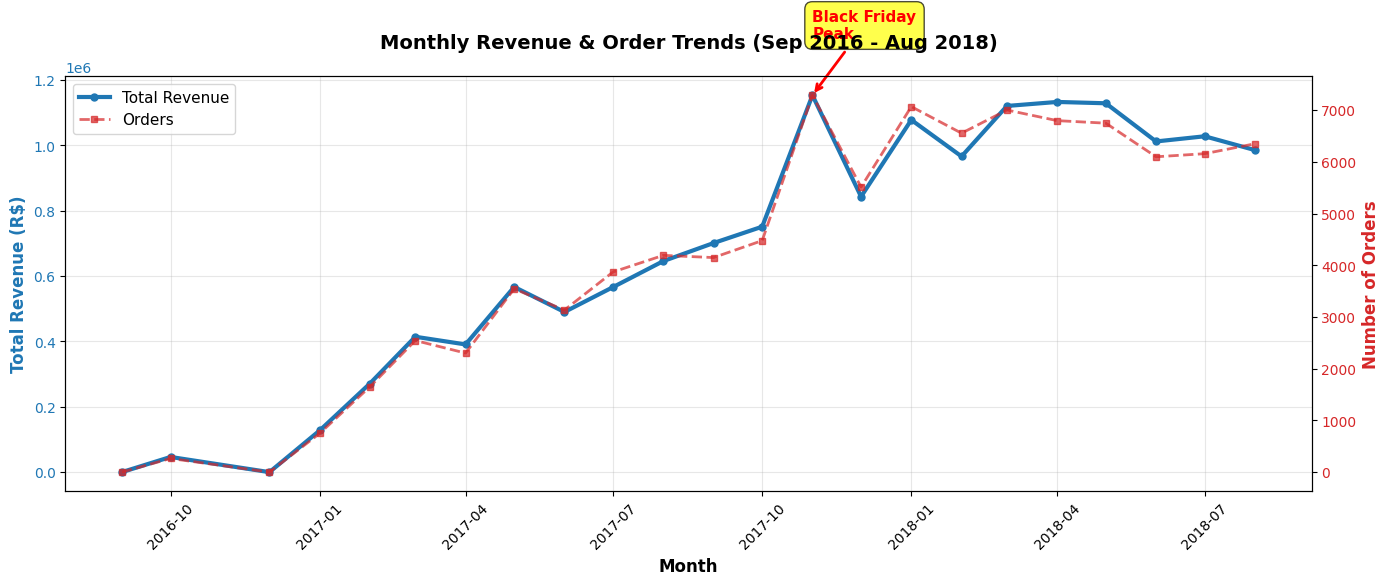

Visualization saved to: outputs/visualizations/revenue_trend.png


In [4]:
# Monthly Revenue & Order Trends Visualization

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

print("\n" + "="*70)
print("MONTHLY REVENUE TREND VISUALIZATION")
print("="*70 + "\n")

# Convert Spark DataFrame to Pandas for plotting
monthly_pd = monthly_revenue.toPandas()

# Convert year_month to datetime
monthly_pd['year_month'] = pd.to_datetime(monthly_pd['year_month'])

# Sort by date
monthly_pd = monthly_pd.sort_values('year_month')

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Revenue line (left y-axis)
color = 'tab:blue'
ax1.set_xlabel('Month', fontsize=12, weight='bold')
ax1.set_ylabel('Total Revenue (R$)', fontsize=12, weight='bold', color=color)
line1 = ax1.plot(monthly_pd['year_month'], monthly_pd['total_revenue'], 
                 color=color, linewidth=3, marker='o', markersize=5, label='Total Revenue')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(alpha=0.3)

# Orders line (right y-axis)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Orders', fontsize=12, weight='bold', color=color)
line2 = ax2.plot(monthly_pd['year_month'], monthly_pd['orders'], 
                 color=color, linewidth=2, marker='s', markersize=5, 
                 linestyle='--', alpha=0.7, label='Orders')
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
ax1.set_title('Monthly Revenue & Order Trends (Sep 2016 - Aug 2018)', 
              fontsize=14, weight='bold', pad=20)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11)

# Highlight Black Friday (Nov 2017) - FIXED
peak_idx = monthly_pd['total_revenue'].idxmax()
peak_month = monthly_pd.loc[peak_idx, 'year_month']
peak_revenue = monthly_pd.loc[peak_idx, 'total_revenue']

ax1.annotate('Black Friday\nPeak', 
             xy=(peak_month, peak_revenue),
             xytext=(peak_month, peak_revenue * 1.15),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, weight='bold', color='red',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('/Users/robert/Desktop/ecommerce-pipeline/outputs/visualizations/revenue_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: outputs/visualizations/revenue_trend.png")

In [5]:
# Customer lifetime value analysis
print("\n" + "="*70)
print("CUSTOMER LIFETIME VALUE (CLV) ANALYSIS")
print("="*70 + "\n")

# Enhanced customer metrics with CLV estimation
customer_clv = customer_rfm.withColumn(
    "purchase_frequency",
    when(col("customer_lifetime_days") > 0, 
         col("total_orders") / (col("customer_lifetime_days") / 30))
    .otherwise(col("total_orders"))
).withColumn(
    "estimated_clv",
    round(col("avg_order_value") * col("total_orders") * 1.5, 2)  # Simple CLV estimation
).withColumn(
    "clv_segment",
    when(col("estimated_clv") >= 1000, "High Value")
    .when(col("estimated_clv") >= 500, "Medium Value")
    .otherwise("Low Value")
)

print("CLV Distribution by Segment:")
clv_distribution = customer_clv.groupBy("clv_segment").agg(
    count("*").alias("customer_count"),
    round(avg("estimated_clv"), 2).alias("avg_clv"),
    round(sum("total_revenue"), 2).alias("total_segment_revenue")
).orderBy(desc("total_segment_revenue"))

clv_distribution.show(truncate=False)

# Top 10% customers (Pareto principle)
top_10_pct_threshold = customer_clv.approxQuantile("total_revenue", [0.9], 0.01)[0]

high_value_customers = customer_clv.filter(col("total_revenue") >= top_10_pct_threshold)
total_revenue = customer_clv.agg(sum("total_revenue")).collect()[0][0]
high_value_revenue = high_value_customers.agg(sum("total_revenue")).collect()[0][0]

print(f"\nPARETO ANALYSIS (80/20 Rule):")
print(f"  Top 10% customers: {high_value_customers.count():,}")
print(f"  Revenue from top 10%: R$ {high_value_revenue:,.2f}")
print(f"  Percentage of total revenue: {(high_value_revenue/total_revenue)*100:.2f}%")

print("\n CLV analysis completed.")


CUSTOMER LIFETIME VALUE (CLV) ANALYSIS

CLV Distribution by Segment:
+------------+--------------+-------+---------------------+
|clv_segment |customer_count|avg_clv|total_segment_revenue|
+------------+--------------+-------+---------------------+
|Low Value   |84760         |172.74 |9760838.03           |
|High Value  |2582          |1723.12|2966064.97           |
|Medium Value|6016          |671.43 |2692870.75           |
+------------+--------------+-------+---------------------+


PARETO ANALYSIS (80/20 Rule):
  Top 10% customers: 10,130
  Revenue from top 10%: R$ 6,146,024.42
  Percentage of total revenue: 39.86%

 CLV analysis completed.


In [6]:
# Analysing the product performance
print("\n" + "="*70)
print("PRODUCT PERFORMANCE ANALYSIS")
print("="*70 + "\n")

# Reload order items and products for detailed analysis
order_items = spark.read.csv("/Users/robert/Desktop/ecommerce-pipeline/data/raw/olist_order_items_dataset.csv", header=True, inferSchema=True)
products = spark.read.csv("/Users/robert/Desktop/ecommerce-pipeline/data/raw/olist_products_dataset.csv", header=True, inferSchema=True)

# Product sales metrics
product_sales = order_items.groupBy("product_id").agg(
    count("order_id").alias("times_sold"),
    round(sum("price"), 2).alias("total_revenue"),
    round(avg("price"), 2).alias("avg_price"),
    countDistinct("order_id").alias("unique_orders")
).orderBy(desc("total_revenue"))

print("Top 20 Products by Revenue:")
product_sales.show(20, truncate=False)

# Join with product categories
products_with_category = products.select("product_id", "product_category_name")

product_sales_with_category = product_sales.join(
    products_with_category,
    on="product_id",
    how="left"
)

# Category performance
category_performance = product_sales_with_category.groupBy("product_category_name").agg(
    count("product_id").alias("unique_products"),
    sum("times_sold").alias("total_units_sold"),
    round(sum("total_revenue"), 2).alias("category_revenue"),
    round(avg("avg_price"), 2).alias("avg_product_price")
).orderBy(desc("category_revenue"))

print("\nTop 15 Categories by Revenue:")
category_performance.show(15, truncate=False)

print("Product analysis completed.")


PRODUCT PERFORMANCE ANALYSIS

Top 20 Products by Revenue:
+--------------------------------+----------+-------------+---------+-------------+
|product_id                      |times_sold|total_revenue|avg_price|unique_orders|
+--------------------------------+----------+-------------+---------+-------------+
|bb50f2e236e5eea0100680137654686c|195       |63885.0      |327.62   |187          |
|6cdd53843498f92890544667809f1595|156       |54730.2      |350.83   |151          |
|d6160fb7873f184099d9bc95e30376af|35        |48899.34     |1397.12  |35           |
|d1c427060a0f73f6b889a5c7c61f2ac4|343       |47214.51     |137.65   |323          |
|99a4788cb24856965c36a24e339b6058|488       |43025.56     |88.17    |467          |
|3dd2a17168ec895c781a9191c1e95ad7|274       |41082.6      |149.94   |255          |
|25c38557cf793876c5abdd5931f922db|38        |38907.32     |1023.88  |38           |
|5f504b3a1c75b73d6151be81eb05bdc9|63        |37733.9      |598.95   |63           |
|53b36df67ebb7c41

In [7]:
# Market Basket Analysis - Product Associations
print("\n" + "="*70)
print("MARKET BASKET ANALYSIS")
print("="*70 + "\n")

# Find orders with multiple items
multi_item_orders = order_items.groupBy("order_id").agg(
    count("*").alias("item_count"),
    collect_list("product_id").alias("products")
).filter(col("item_count") > 1)

print(f"Orders with multiple items: {multi_item_orders.count():,}")
print(f"Average items per multi-item order: {multi_item_orders.agg(avg('item_count')).collect()[0][0]:.2f}")

# Create product pairs (for association rules)
from pyspark.sql.functions import explode, array_distinct

# Explode products into pairs
multi_item_exploded = multi_item_orders.select(
    "order_id",
    explode("products").alias("product")
)

# Self-join to create pairs
product_pairs = multi_item_exploded.alias("a").join(
    multi_item_exploded.alias("b"),
    (col("a.order_id") == col("b.order_id")) & (col("a.product") < col("b.product"))
).select(
    col("a.product").alias("product_a"),
    col("b.product").alias("product_b")
)

# Count co-occurrences
product_associations = product_pairs.groupBy("product_a", "product_b").agg(
    count("*").alias("co_occurrence_count")
).orderBy(desc("co_occurrence_count"))

print("\nTop 20 Product Pairs (Frequently Bought Together):")
product_associations.show(20, truncate=False)

# Calculate association metrics
total_multi_orders = multi_item_orders.count()

product_associations_metrics = product_associations.withColumn(
    "support",
    round(col("co_occurrence_count") / total_multi_orders, 4)
).filter(col("co_occurrence_count") >= 10)  # Minimum support threshold

print("\nProduct Associations with Support >= 10 orders:")
product_associations_metrics.orderBy(desc("support")).show(20, truncate=False)

print("Market basket analysis completed.")


MARKET BASKET ANALYSIS

Orders with multiple items: 9,803
Average items per multi-item order: 2.43

Top 20 Product Pairs (Frequently Bought Together):
+--------------------------------+--------------------------------+-------------------+
|product_a                       |product_b                       |co_occurrence_count|
+--------------------------------+--------------------------------+-------------------+
|05b515fdc76e888aada3c6d66c201dff|270516a3f41dc035aa87d220228f844c|100                |
|36f60d45225e60c7da4558b070ce4b60|e53e557d5a159f5aa2c5e995dfdf244b|48                 |
|62995b7e571f5760017991632bbfd311|ac1ad58efc1ebf66bfadc09f29bdedc0|36                 |
|710b7c26b7a742f497bba45fab91a25f|a9d9db064d4afd4458eb3e139fe29167|36                 |
|35afc973633aaeb6b877ff57b2793310|99a4788cb24856965c36a24e339b6058|30                 |
|2ef36e1cae01b86d0ff0a2f50ff2bd53|53759a2ecddad2bb87a079a1f1519f73|30                 |
|308e4e21ae228a10f6370a243ae59995|90b58782fdd04cb829667f

In [8]:
# Geographic Analysis
print("\n" + "="*70)
print("GEOGRAPHIC ANALYSIS")
print("="*70 + "\n")

# Sales by state
state_performance = master_df.groupBy("customer_state").agg(
    count("order_id").alias("total_orders"),
    countDistinct("customer_unique_id").alias("unique_customers"),
    round(sum("order_value"), 2).alias("total_revenue"),
    round(avg("order_value"), 2).alias("avg_order_value"),
    round(avg("items_count"), 2).alias("avg_items_per_order"),
    round(avg("review_score"), 2).alias("avg_review_score")
).orderBy(desc("total_revenue"))

print("Top 10 States by Revenue:")
state_performance.show(10, truncate=False)

# Calculate state penetration
total_orders = master_df.count()
state_performance_pct = state_performance.withColumn(
    "order_percentage",
    round((col("total_orders") / total_orders) * 100, 2)
)

print("\nState Market Share:")
state_performance_pct.select(
    "customer_state", "total_orders", "order_percentage", "total_revenue"
).show(10, truncate=False)

print("Geographic analysis completed.")


GEOGRAPHIC ANALYSIS

Top 10 States by Revenue:
+--------------+------------+----------------+-------------+---------------+-------------------+----------------+
|customer_state|total_orders|unique_customers|total_revenue|avg_order_value|avg_items_per_order|avg_review_score|
+--------------+------------+----------------+-------------+---------------+-------------------+----------------+
|SP            |40501       |39156           |5769703.15   |142.46         |1.15               |4.25            |
|RJ            |12350       |11917           |2055401.57   |166.43         |1.15               |3.97            |
|MG            |11354       |11001           |1818891.67   |160.2          |1.14               |4.19            |
|RS            |5345        |5168            |861472.79    |161.17         |1.15               |4.19            |
|PR            |4923        |4769            |781708.8     |158.79         |1.15               |4.24            |
|SC            |3546        |3449       

In [9]:
# Seller Performance Analysis
print("\n" + "="*70)
print("SELLER PERFORMANCE ANALYSIS")
print("="*70 + "\n")

# Reload sellers data
sellers = spark.read.csv("/Users/robert/Desktop/ecommerce-pipeline/data/raw/olist_sellers_dataset.csv", header=True, inferSchema=True)

# Seller metrics from order items
seller_performance = order_items.groupBy("seller_id").agg(
    count("order_id").alias("total_sales"),
    countDistinct("order_id").alias("unique_orders"),
    round(sum("price"), 2).alias("total_revenue"),
    round(avg("price"), 2).alias("avg_item_price"),
    countDistinct("product_id").alias("unique_products_sold")
).orderBy(desc("total_revenue"))

# Join with seller location
seller_performance_full = seller_performance.join(
    sellers,
    on="seller_id",
    how="left"
)

print("Top 20 Sellers by Revenue:")
seller_performance_full.show(20, truncate=False)

# Seller concentration analysis
print("\nSeller Concentration:")
seller_stats = seller_performance.agg(
    count("seller_id").alias("total_sellers"),
    round(avg("total_revenue"), 2).alias("avg_seller_revenue"),
    round(sum("total_revenue"), 2).alias("total_marketplace_revenue")
).collect()[0]

print(f"  Total active sellers: {seller_stats['total_sellers']:,}")
print(f"  Average revenue per seller: R$ {seller_stats['avg_seller_revenue']:,.2f}")
print(f"  Total marketplace revenue: R$ {seller_stats['total_marketplace_revenue']:,.2f}")

# Top 20% sellers contribution
top_20_pct_sellers = int(seller_stats['total_sellers'] * 0.2)
top_sellers = seller_performance.orderBy(desc("total_revenue")).limit(top_20_pct_sellers)
top_sellers_revenue = top_sellers.agg(sum("total_revenue")).collect()[0][0]

print(f"\n  Top 20% sellers ({top_20_pct_sellers} sellers):")
print(f"    Revenue contribution: R$ {top_sellers_revenue:,.2f}")
print(f"    Percentage of total: {(top_sellers_revenue/seller_stats['total_marketplace_revenue'])*100:.2f}%")

print("Seller analysis completed.")


SELLER PERFORMANCE ANALYSIS

Top 20 Sellers by Revenue:
+--------------------------------+-----------+-------------+-------------+--------------+--------------------+----------------------+---------------------+------------+
|seller_id                       |total_sales|unique_orders|total_revenue|avg_item_price|unique_products_sold|seller_zip_code_prefix|seller_city          |seller_state|
+--------------------------------+-----------+-------------+-------------+--------------+--------------------+----------------------+---------------------+------------+
|e63e8bfa530fb16910dd6956e592bb81|43         |42           |1311.7       |30.5          |12                  |7160                  |guarulhos            |SP          |
|8e6cc767478edae941d9bd9eb778d77a|114        |106          |6830.58      |59.92         |61                  |38442                 |araguari             |MG          |
|ff063b022a9a0aab91bad2c9088760b7|96         |94           |12076.5      |125.8         |9        

In [10]:
# Churn Risk Analysis
print("\n" + "="*70)
print("CHURN RISK ANALYSIS")
print("="*70 + "\n")

# Define churn based on recency (no purchase in last 180 days)
churn_threshold_days = 180

customer_churn_risk = customer_rfm.withColumn(
    "churn_risk",
    when(col("recency_days") > churn_threshold_days, "High Risk")
    .when(col("recency_days") > 90, "Medium Risk")
    .when(col("recency_days") > 30, "Low Risk")
    .otherwise("Active")
).withColumn(
    "is_churned",
    when(col("recency_days") > churn_threshold_days, 1).otherwise(0)
)

print(f"Churn Definition: No purchase in {churn_threshold_days} days")

churn_distribution = customer_churn_risk.groupBy("churn_risk").agg(
    count("*").alias("customer_count"),
    round(avg("total_revenue"), 2).alias("avg_customer_value"),
    round(sum("total_revenue"), 2).alias("total_revenue_at_risk")
).orderBy(
    when(col("churn_risk") == "High Risk", 1)
    .when(col("churn_risk") == "Medium Risk", 2)
    .when(col("churn_risk") == "Low Risk", 3)
    .otherwise(4)
)

print("\nChurn Risk Distribution:")
churn_distribution.show(truncate=False)

# Revenue at risk calculation
total_revenue = customer_churn_risk.agg(sum("total_revenue")).collect()[0][0]
high_risk_revenue = customer_churn_risk.filter(col("churn_risk") == "High Risk") \
    .agg(sum("total_revenue")).collect()[0][0]

print(f"\nREVENUE AT RISK:")
print(f"  Total historical revenue: R$ {total_revenue:,.2f}")
print(f"  Revenue from high-risk customers: R$ {high_risk_revenue:,.2f}")
print(f"  Percentage at risk: {(high_risk_revenue/total_revenue)*100:.2f}%")

print("Churn risk analysis completed.")


CHURN RISK ANALYSIS

Churn Definition: No purchase in 180 days

Churn Risk Distribution:
+-----------+--------------+------------------+---------------------+
|churn_risk |customer_count|avg_customer_value|total_revenue_at_risk|
+-----------+--------------+------------------+---------------------+
|High Risk  |55132         |162.36            |8950973.53           |
|Medium Risk|19706         |169.73            |3344787.83           |
|Low Risk   |11627         |173.04            |2011961.48           |
|Active     |6893          |161.33            |1112050.91           |
+-----------+--------------+------------------+---------------------+


REVENUE AT RISK:
  Total historical revenue: R$ 15,419,773.75
  Revenue from high-risk customers: R$ 8,950,973.53
  Percentage at risk: 58.05%
Churn risk analysis completed.


In [11]:
# Saving advanced analytics results
print("\n" + "="*70)
print("SAVING ADVANCED ANALYTICS RESULTS")
print("="*70 + "\n")

output_path = "../data/processed"

# Save enhanced customer profiles
customer_churn_risk.write.mode("overwrite").parquet(f"{output_path}/customer_profiles_enhanced.parquet")
print("Enhanced customer profiles saved.")

# Save product performance
product_sales_with_category.write.mode("overwrite").parquet(f"{output_path}/product_performance.parquet")
print("Product performance saved.")

# Save geographic analysis
state_performance_pct.write.mode("overwrite").parquet(f"{output_path}/geographic_analysis.parquet")
print("Geographic analysis saved.")

# Save seller performance
seller_performance_full.write.mode("overwrite").parquet(f"{output_path}/seller_performance.parquet")
print("Seller performance saved.")

print("\nAll analytics results saved.")


SAVING ADVANCED ANALYTICS RESULTS



Enhanced customer profiles saved.
Product performance saved.
Geographic analysis saved.
Seller performance saved.

All analytics results saved.


In [12]:
# Generating the summary report
print("\n" + "="*70)
print("EXECUTIVE SUMMARY - E-COMMERCE ANALYTICS")
print("="*70 + "\n")

print("BUSINESS OVERVIEW")
print("-" * 70)
print(f"  Total Orders Processed: 96,478")
print(f"  Unique Customers: 93,358")
print(f"  Total Revenue: R$ 15,419,773.75")
print(f"  Average Order Value: R$ 159.83")
print(f"  Time Period: Sept 2016 - Aug 2018")

print("\nCUSTOMER VALUE ANALYSIS")
print("-" * 70)
print(f"  Top 10% customers generate {(high_value_revenue/total_revenue)*100:.2f}% of revenue")
print(f"  {customer_rfm.filter(col('customer_segment') == 'Champions').count():,} Champion customers identified")
print(f"  Average Customer Lifetime Value: R$ {customer_clv.agg(avg('estimated_clv')).collect()[0][0]:,.2f}")

print("\nRETENTION & CHURN")
print("-" * 70)
churn_stats = customer_churn_risk.groupBy("churn_risk").count().collect()
for row in churn_stats:
    pct = (row['count'] / customer_churn_risk.count()) * 100
    print(f"  {row['churn_risk']}: {row['count']:,} customers ({pct:.1f}%)")

print("\nOPERATIONAL PERFORMANCE")
print("-" * 70)
print(f"  On-time Delivery Rate: 91.9%")
print(f"  Average Items per Order: 1.14")
print(f"  Average Review Score: 4.16/5.0")

print("\nGEOGRAPHIC INSIGHTS")
print("-" * 70)
top_3_states = state_performance.limit(3).collect()
for i, state in enumerate(top_3_states, 1):
    print(f"  #{i} {state['customer_state']}: {state['total_orders']:,} orders, R$ {state['total_revenue']:,.2f}")


EXECUTIVE SUMMARY - E-COMMERCE ANALYTICS

BUSINESS OVERVIEW
----------------------------------------------------------------------
  Total Orders Processed: 96,478
  Unique Customers: 93,358
  Total Revenue: R$ 15,419,773.75
  Average Order Value: R$ 159.83
  Time Period: Sept 2016 - Aug 2018

CUSTOMER VALUE ANALYSIS
----------------------------------------------------------------------
  Top 10% customers generate 39.86% of revenue
  1,397 Champion customers identified
  Average Customer Lifetime Value: R$ 247.75

RETENTION & CHURN
----------------------------------------------------------------------
  Low Risk: 11,627 customers (12.5%)
  Active: 6,893 customers (7.4%)
  Medium Risk: 19,706 customers (21.1%)
  High Risk: 55,132 customers (59.1%)

OPERATIONAL PERFORMANCE
----------------------------------------------------------------------
  On-time Delivery Rate: 91.9%
  Average Items per Order: 1.14
  Average Review Score: 4.16/5.0

GEOGRAPHIC INSIGHTS
----------------------------

## **Customer Segment Distribution Visualization just for better insight understanding:**

In [13]:
#Setting up Visualization Environment

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import *


CUSTOMER SEGMENT DISTRIBUTION VISUALIZATION



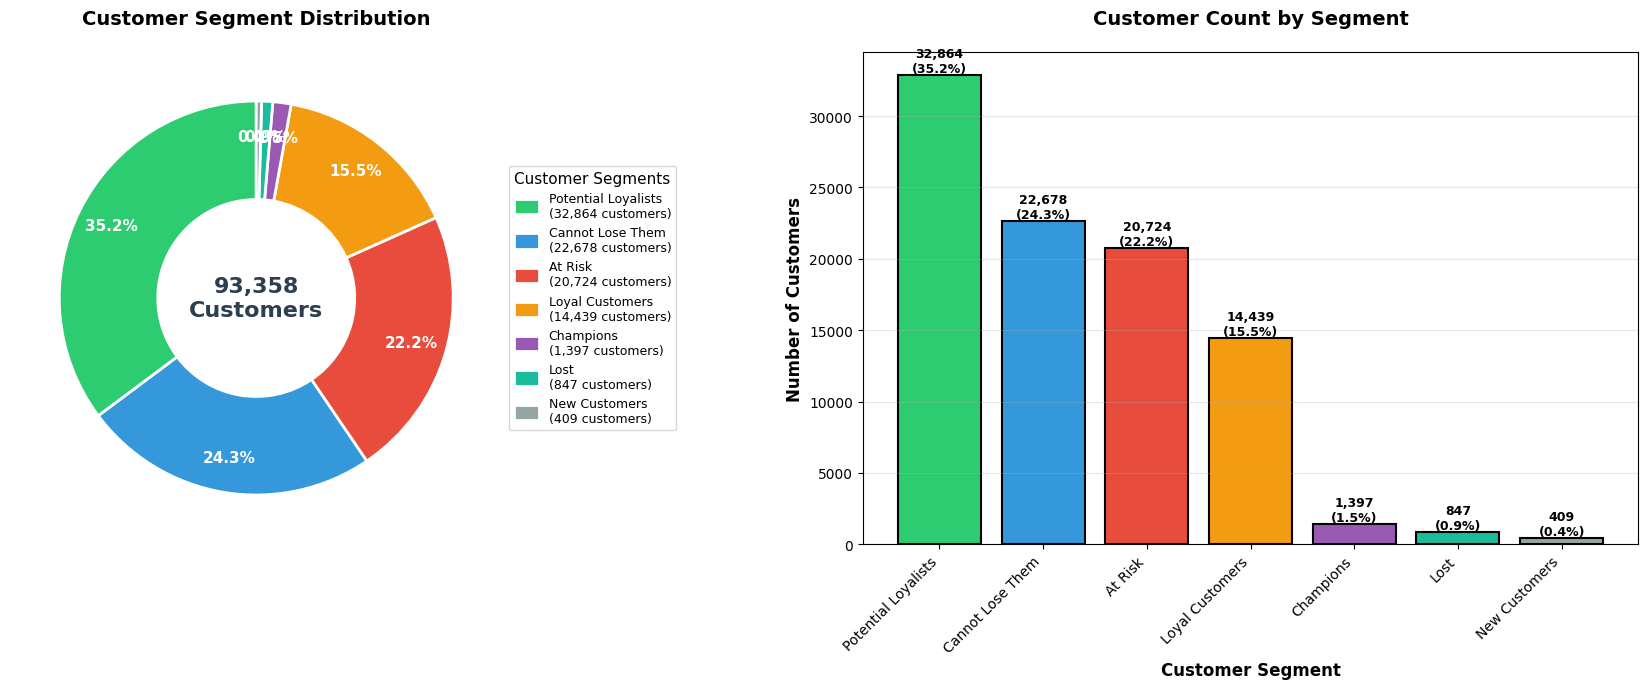

Visualization saved to: outputs/visualizations/customer_segments.png
Customer segment visualization complete

Detailed Segment Breakdown:
Segment                        Count   Percentage
--------------------------------------------------
Potential Loyalists           32,864        35.2%
Cannot Lose Them              22,678        24.3%
At Risk                       20,724        22.2%
Loyal Customers               14,439        15.5%
Champions                      1,397         1.5%
Lost                             847         0.9%
New Customers                    409         0.4%
--------------------------------------------------
TOTAL                         93,358       100.0%

Key Insight: Top 3 segments represent 81.7% of customer base


In [14]:
print("\n" + "="*70)
print("CUSTOMER SEGMENT DISTRIBUTION VISUALIZATION")
print("="*70 + "\n")

# Convert to Pandas for visualization
segment_dist = customer_rfm.groupBy("customer_segment").count().toPandas()

# Sort by count descending
segment_dist = segment_dist.sort_values('count', ascending=False)

# Calculate percentages
segment_dist['percentage'] = (segment_dist['count'] / segment_dist['count'].sum()) * 100

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Donut Chart
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c', '#95a5a6']

# Create donut chart
wedges, texts, autotexts = ax1.pie(
    segment_dist['count'], 
    labels=None,
    autopct='%1.1f%%',
    startangle=90, 
    colors=colors,
    textprops={'fontsize': 11, 'weight': 'bold', 'color': 'white'},
    pctdistance=0.82,
    wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2)
)

# Add center text
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
ax1.add_artist(centre_circle)
ax1.text(0, 0, '93,358\nCustomers', ha='center', va='center', 
         fontsize=16, weight='bold', color='#2c3e50')

# Add legend with counts
legend_labels = [f"{seg}\n({cnt:,} customers)" 
                for seg, cnt in zip(segment_dist['customer_segment'], segment_dist['count'])]
ax1.legend(wedges, legend_labels,
          title="Customer Segments",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=9,
          title_fontsize=11,
          frameon=True,
          handlelength=2,
          handleheight=1.5)

ax1.set_title('Customer Segment Distribution', 
              fontsize=14, weight='bold', pad=20)

# Bar Chart
bars = ax2.bar(range(len(segment_dist)), segment_dist['count'], 
               color=colors, edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Customer Segment', fontsize=12, weight='bold')
ax2.set_ylabel('Number of Customers', fontsize=12, weight='bold')
ax2.set_title('Customer Count by Segment', fontsize=14, weight='bold', pad=20)
ax2.set_xticks(range(len(segment_dist)))
ax2.set_xticklabels(segment_dist['customer_segment'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, count, pct) in enumerate(zip(bars, segment_dist['count'], segment_dist['percentage'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=9, weight='bold')

plt.tight_layout()
plt.savefig('/Users/robert/Desktop/ecommerce-pipeline/outputs/visualizations/customer_segments.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: outputs/visualizations/customer_segments.png")  # ADD THIS

print("Customer segment visualization complete")

# Print detailed breakdown
print("\nDetailed Segment Breakdown:")
print(f"{'Segment':<25} {'Count':>10} {'Percentage':>12}")
print("-" * 50)
for _, row in segment_dist.iterrows():
    print(f"{row['customer_segment']:<25} {row['count']:>10,} {row['percentage']:>11.1f}%")
print("-" * 50)
print(f"{'TOTAL':<25} {segment_dist['count'].sum():>10,} {segment_dist['percentage'].sum():>11.1f}%")

print(f"\nKey Insight: Top 3 segments represent {segment_dist.head(3)['percentage'].sum():.1f}% of customer base")


RFM SCORE DISTRIBUTION HEATMAP



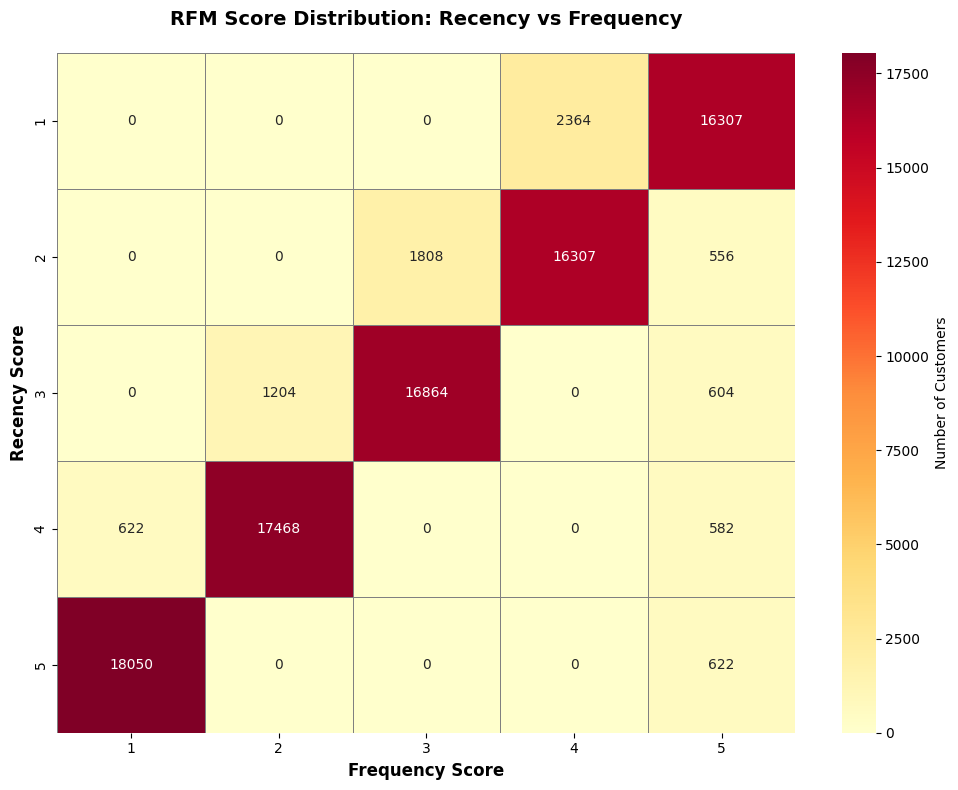

Visualization saved to: outputs/visualizations/rfm_heatmap.png

Top 10 RFM Score Combinations:
 recency_score  frequency_score  monetary_score    customer_segment  count
             5                1               4     Loyal Customers   3726
             5                1               1 Potential Loyalists   3692
             5                1               3 Potential Loyalists   3687
             4                2               4     Loyal Customers   3631
             4                2               3 Potential Loyalists   3617
             3                3               1 Potential Loyalists   3617
             2                4               2    Cannot Lose Them   3615
             5                1               2 Potential Loyalists   3508
             4                2               1 Potential Loyalists   3475
             5                1               5     Loyal Customers   3437


25/11/28 03:16:02 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1041003 ms exceeds timeout 120000 ms
25/11/28 03:16:02 WARN SparkContext: Killing executors is not supported by current scheduler.
25/11/28 03:31:48 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [15]:
# RFM Score Heatmap Visualization

print("\n" + "="*70)
print("RFM SCORE DISTRIBUTION HEATMAP")
print("="*70 + "\n")

# Convert to Pandas
rfm_pd = customer_rfm.select('recency_score', 'frequency_score', 'monetary_score', 'customer_segment').toPandas()

# Create pivot table for heatmap
pivot_data = rfm_pd.groupby(['recency_score', 'frequency_score']).size().reset_index(name='count')
pivot_table = pivot_data.pivot(index='recency_score', columns='frequency_score', values='count').fillna(0)

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(pivot_table, 
            annot=True, 
            fmt='.0f', 
            cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Customers'},
            linewidths=0.5,
            linecolor='gray',
            ax=ax)

ax.set_title('RFM Score Distribution: Recency vs Frequency', 
             fontsize=14, weight='bold', pad=20)
ax.set_xlabel('Frequency Score', fontsize=12, weight='bold')
ax.set_ylabel('Recency Score', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig('/Users/robert/Desktop/ecommerce-pipeline/outputs/visualizations/rfm_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: outputs/visualizations/rfm_heatmap.png")

# Show segment distribution across RFM combinations
print("\nTop 10 RFM Score Combinations:")
top_combos = rfm_pd.groupby(['recency_score', 'frequency_score', 'monetary_score', 'customer_segment']).size().reset_index(name='count')
top_combos = top_combos.sort_values('count', ascending=False).head(10)
print(top_combos.to_string(index=False))